### 5.5) Gathering Input Graphs

In [13]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html


In [14]:
import torch
from torch_geometric.data import Data
from torch.serialization import add_safe_globals
import os

# Allow PyTorch to unpickle torch_geometric.data.Data objects
add_safe_globals([Data])

# Then load the files
graph_dir = "/kaggle/input/chicken-graph-data-edge-attr/graph_data_zip"
pt_files = [f for f in os.listdir(graph_dir) if f.endswith('.pt')]

graphs = [
    torch.load(os.path.join(graph_dir, f), weights_only=False)
    for f in pt_files
]

In [15]:
graphs

[Data(x=[560, 560], edge_index=[2, 440258], edge_attr=[440258, 3], y=[1]),
 Data(x=[603, 603], edge_index=[2, 319768], edge_attr=[319768, 3], y=[1]),
 Data(x=[525, 525], edge_index=[2, 92854], edge_attr=[92854, 3], y=[1]),
 Data(x=[648, 648], edge_index=[2, 477458], edge_attr=[477458, 3], y=[1]),
 Data(x=[484, 484], edge_index=[2, 327346], edge_attr=[327346, 3], y=[1]),
 Data(x=[430, 430], edge_index=[2, 295144], edge_attr=[295144, 3], y=[1]),
 Data(x=[716, 716], edge_index=[2, 348140], edge_attr=[348140, 3], y=[1]),
 Data(x=[706, 706], edge_index=[2, 401906], edge_attr=[401906, 3], y=[1]),
 Data(x=[577, 577], edge_index=[2, 488282], edge_attr=[488282, 3], y=[1]),
 Data(x=[599, 599], edge_index=[2, 582338], edge_attr=[582338, 3], y=[1]),
 Data(x=[451, 451], edge_index=[2, 274074], edge_attr=[274074, 3], y=[1]),
 Data(x=[426, 426], edge_index=[2, 277242], edge_attr=[277242, 3], y=[1]),
 Data(x=[591, 591], edge_index=[2, 571268], edge_attr=[571268, 3], y=[1]),
 Data(x=[199, 199], edge_in

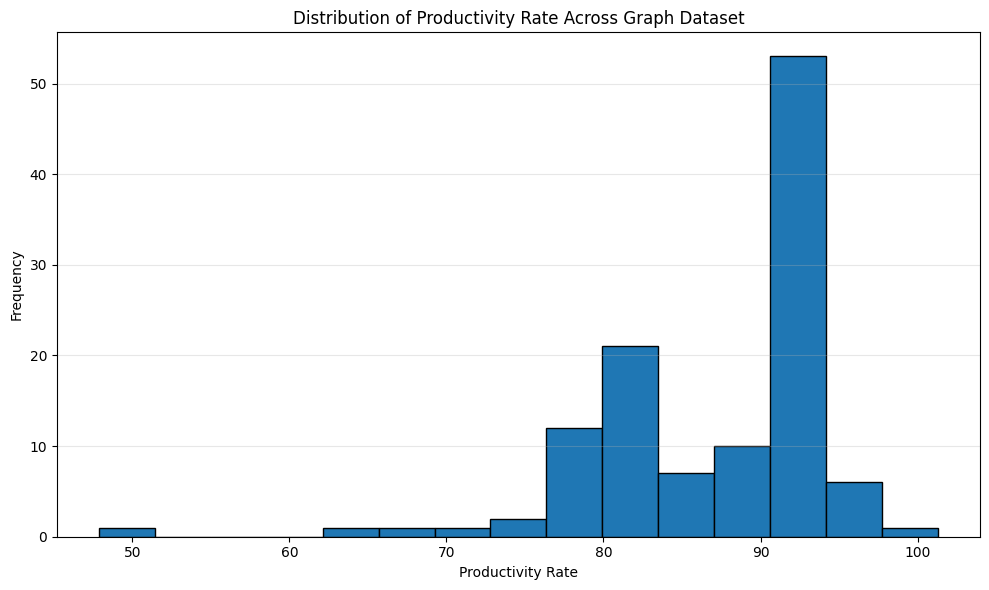

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

rates = []
for graph in graphs:
    if hasattr(graph, 'y'):
        val = graph.y.item() if graph.y.numel() == 1 else float(graph.y[0])
        rates.append(val)

plt.figure(figsize=(10, 6))
plt.hist(rates, bins=15, edgecolor='black')
plt.xlabel("Productivity Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Productivity Rate Across Graph Dataset")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Productivity rate = (Eggs Laid / Number of Hens) x 100.

The majority of days are over 90, which is a high productivity rate. The smallest rate was under 60 one day and the largest was a perfect 100.

In [17]:
# padding so model can expect a fixed set of dimensions from graphs

max_node_dim = max(g.x.shape[1] for g in graphs)
max_edge_dim = max(g.edge_attr.shape[1] for g in graphs)

def pad_features(graph, max_node_dim, max_edge_dim):
    # Pad node features
    node_feat = graph.x
    if node_feat.shape[1] < max_node_dim:
        pad_size = max_node_dim - node_feat.shape[1]
        padding = torch.zeros((node_feat.shape[0], pad_size), dtype=node_feat.dtype)
        graph.x = torch.cat([node_feat, padding], dim=1)
    
    # Pad edge features
    edge_feat = graph.edge_attr
    if edge_feat.shape[1] < max_edge_dim:
        pad_size = max_edge_dim - edge_feat.shape[1]
        padding = torch.zeros((edge_feat.shape[0], pad_size), dtype=edge_feat.dtype)
        graph.edge_attr = torch.cat([edge_feat, padding], dim=1)
    
    return graph

In [18]:
graphs_padded = [pad_features(g, max_node_dim, max_edge_dim) for g in graphs]

### 6) Create GAT Model for Graph Regression¶

GAT model takes graph as input, applies GAT layers to learn node embeddings, aggregates (mean pooling or attention pooling) to a graph level embedding, and passes that to fully connected layers to predict a single value (productivity)

global mean pooling

In [19]:
# using edge_attr properly

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATv2Conv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2, edge_dim=in_edge_feats)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2, edge_dim=in_edge_feats)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = global_mean_pool(x, batch)
        return self.mlp(x).squeeze(1)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion, device):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae, preds, targets

# Replace these with your actual data and dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Make sure `graphs_padded` is defined and has x, edge_index, edge_attr, y, batch
# Also make sure all graphs have same node feature dimension and edge feature dimension
in_node_feats = graphs_padded[0].x.shape[1]
in_edge_feats = graphs_padded[0].edge_attr.shape[1]

all_rmse = []
all_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=in_node_feats, in_edge_feats=in_edge_feats).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, rmse, mae, _, _ = eval_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Load best model and evaluate on validation set
    model.load_state_dict(torch.load(f"best_model_fold{fold}.pt"))
    _, rmse, mae, preds, targets = eval_model(model, val_loader, criterion, device)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")


Fold 1
Epoch 0 | Train Loss: 7747.2381 | Val Loss: 7376.8800 | RMSE: 85.8888 | MAE: 85.6756
Epoch 1 | Train Loss: 7684.8188 | Val Loss: 7289.3118 | RMSE: 85.3775 | MAE: 85.1630
Epoch 2 | Train Loss: 7576.7651 | Val Loss: 7160.8079 | RMSE: 84.6216 | MAE: 84.4051
Epoch 3 | Train Loss: 7434.6373 | Val Loss: 6995.9059 | RMSE: 83.6415 | MAE: 83.4224
Epoch 4 | Train Loss: 7246.0954 | Val Loss: 6786.3007 | RMSE: 82.3790 | MAE: 82.1563
Epoch 5 | Train Loss: 6997.1636 | Val Loss: 6505.1440 | RMSE: 80.6545 | MAE: 80.4268
Epoch 6 | Train Loss: 6705.6713 | Val Loss: 6155.6032 | RMSE: 78.4576 | MAE: 78.2233
Epoch 7 | Train Loss: 6261.5476 | Val Loss: 5657.8938 | RMSE: 75.2190 | MAE: 74.9742
Epoch 8 | Train Loss: 5755.8618 | Val Loss: 5166.9727 | RMSE: 71.8817 | MAE: 71.6254
Epoch 9 | Train Loss: 5285.2191 | Val Loss: 4683.7761 | RMSE: 68.4381 | MAE: 68.1684
Epoch 10 | Train Loss: 4718.6751 | Val Loss: 4032.9803 | RMSE: 63.5058 | MAE: 63.2151
Epoch 11 | Train Loss: 4022.9962 | Val Loss: 3360.0161 | 

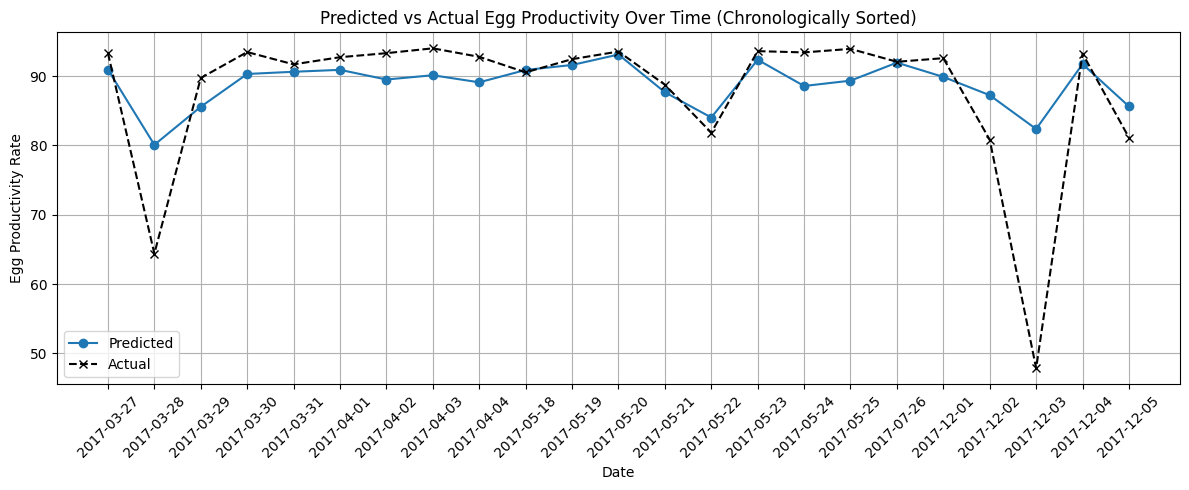

In [20]:
n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine into a single dataframe and sort by date
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time (Chronologically Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

global_max_pool instead of global_mean_pool

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_max_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, edge_dim, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2, edge_dim=edge_dim, add_self_loops=False)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2, edge_dim=edge_dim, add_self_loops=False)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = global_max_pool(x, batch)
        return self.mlp(x).squeeze(1)

# Normalize targets
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kf = KFold(n_splits=5, shuffle=True, random_state=0)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae, preds, targets

all_rmse = []
all_mae = []

# Assume edge_attr is consistent across graphs and has fixed dim
edge_dim = graphs_padded[0].edge_attr.shape[1]

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=max_node_dim, edge_dim=edge_dim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, rmse, mae, _, _ = eval_model(model, val_loader, criterion)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_max_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(f"best_model_max_fold{fold}.pt"))
    _, rmse, mae, preds, targets = eval_model(model, val_loader, criterion)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

Fold 1


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.1018 | Val Loss: 0.6300 | RMSE: 0.7937 | MAE: 0.7232


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.0929 | Val Loss: 0.6375 | RMSE: 0.7984 | MAE: 0.7258


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0853 | Val Loss: 0.6373 | RMSE: 0.7983 | MAE: 0.7240


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0816 | Val Loss: 0.6437 | RMSE: 0.8023 | MAE: 0.7258


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0635 | Val Loss: 0.6467 | RMSE: 0.8042 | MAE: 0.7264


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0545 | Val Loss: 0.6375 | RMSE: 0.7984 | MAE: 0.7235


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 1.0362 | Val Loss: 0.6365 | RMSE: 0.7978 | MAE: 0.7218


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 1.0184 | Val Loss: 0.6370 | RMSE: 0.7981 | MAE: 0.7203


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.9992 | Val Loss: 0.6302 | RMSE: 0.7939 | MAE: 0.7156


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.9749 | Val Loss: 0.6303 | RMSE: 0.7939 | MAE: 0.7164


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.9422 | Val Loss: 0.6151 | RMSE: 0.7843 | MAE: 0.7079


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.9043 | Val Loss: 0.6027 | RMSE: 0.7764 | MAE: 0.7015


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.8668 | Val Loss: 0.5974 | RMSE: 0.7729 | MAE: 0.7013


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.8123 | Val Loss: 0.5844 | RMSE: 0.7644 | MAE: 0.6910


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.7830 | Val Loss: 0.5721 | RMSE: 0.7564 | MAE: 0.6850


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.7037 | Val Loss: 0.5473 | RMSE: 0.7398 | MAE: 0.6691


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.6216 | Val Loss: 0.5197 | RMSE: 0.7209 | MAE: 0.6492


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.5596 | Val Loss: 0.5073 | RMSE: 0.7123 | MAE: 0.6470


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.4952 | Val Loss: 0.4941 | RMSE: 0.7029 | MAE: 0.6369


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.4313 | Val Loss: 0.4543 | RMSE: 0.6740 | MAE: 0.6158


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.3895 | Val Loss: 0.4752 | RMSE: 0.6893 | MAE: 0.6118


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.3633 | Val Loss: 0.4629 | RMSE: 0.6803 | MAE: 0.6157


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.3161 | Val Loss: 0.4345 | RMSE: 0.6592 | MAE: 0.5883


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.2724 | Val Loss: 0.4291 | RMSE: 0.6551 | MAE: 0.5770


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.2577 | Val Loss: 0.4226 | RMSE: 0.6501 | MAE: 0.5740


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.2248 | Val Loss: 0.3994 | RMSE: 0.6320 | MAE: 0.5636


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.2144 | Val Loss: 0.4337 | RMSE: 0.6586 | MAE: 0.5809


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.1800 | Val Loss: 0.3988 | RMSE: 0.6315 | MAE: 0.5669


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.1789 | Val Loss: 0.3989 | RMSE: 0.6316 | MAE: 0.5648


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.1589 | Val Loss: 0.3693 | RMSE: 0.6077 | MAE: 0.5317


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.1579 | Val Loss: 0.3969 | RMSE: 0.6300 | MAE: 0.5506


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.1410 | Val Loss: 0.4347 | RMSE: 0.6593 | MAE: 0.5841


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.1291 | Val Loss: 0.4190 | RMSE: 0.6473 | MAE: 0.5819


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.1127 | Val Loss: 0.4440 | RMSE: 0.6663 | MAE: 0.5617


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.0995 | Val Loss: 0.4199 | RMSE: 0.6480 | MAE: 0.5742


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.0913 | Val Loss: 0.3899 | RMSE: 0.6244 | MAE: 0.5581


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.0946 | Val Loss: 0.3831 | RMSE: 0.6190 | MAE: 0.5380


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.0815 | Val Loss: 0.4101 | RMSE: 0.6404 | MAE: 0.5698


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 38 | Train Loss: 0.0819 | Val Loss: 0.3907 | RMSE: 0.6251 | MAE: 0.5498


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 39 | Train Loss: 0.0825 | Val Loss: 0.4567 | RMSE: 0.6758 | MAE: 0.5835
Early stopping triggered.
Fold 1 final RMSE: 0.6077, MAE: 0.5317
Fold 2


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.1022 | Val Loss: 0.6381 | RMSE: 0.7988 | MAE: 0.7268


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.0876 | Val Loss: 0.6570 | RMSE: 0.8106 | MAE: 0.7389


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0692 | Val Loss: 0.6670 | RMSE: 0.8167 | MAE: 0.7451


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0647 | Val Loss: 0.6797 | RMSE: 0.8244 | MAE: 0.7517


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0464 | Val Loss: 0.6876 | RMSE: 0.8292 | MAE: 0.7562


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0349 | Val Loss: 0.6919 | RMSE: 0.8318 | MAE: 0.7588


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 1.0272 | Val Loss: 0.7109 | RMSE: 0.8432 | MAE: 0.7680


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 1.0113 | Val Loss: 0.7089 | RMSE: 0.8420 | MAE: 0.7674


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.9879 | Val Loss: 0.7263 | RMSE: 0.8523 | MAE: 0.7764


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.9650 | Val Loss: 0.7167 | RMSE: 0.8466 | MAE: 0.7712


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.9499 | Val Loss: 0.7117 | RMSE: 0.8437 | MAE: 0.7685
Early stopping triggered.
Fold 2 final RMSE: 0.7988, MAE: 0.7268
Fold 3


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.0333 | Val Loss: 0.9420 | RMSE: 0.9706 | MAE: 0.8392


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.0243 | Val Loss: 0.9415 | RMSE: 0.9703 | MAE: 0.8381


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0224 | Val Loss: 0.9339 | RMSE: 0.9664 | MAE: 0.8384


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0143 | Val Loss: 0.9314 | RMSE: 0.9651 | MAE: 0.8386


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0126 | Val Loss: 0.9247 | RMSE: 0.9616 | MAE: 0.8367


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0067 | Val Loss: 0.9178 | RMSE: 0.9580 | MAE: 0.8355


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.9986 | Val Loss: 0.9202 | RMSE: 0.9593 | MAE: 0.8359


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.9936 | Val Loss: 0.9146 | RMSE: 0.9563 | MAE: 0.8325


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.9800 | Val Loss: 0.9122 | RMSE: 0.9551 | MAE: 0.8321


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.9651 | Val Loss: 0.9057 | RMSE: 0.9517 | MAE: 0.8304


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.9507 | Val Loss: 0.9027 | RMSE: 0.9501 | MAE: 0.8269


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.9324 | Val Loss: 0.8962 | RMSE: 0.9467 | MAE: 0.8232


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.9012 | Val Loss: 0.8861 | RMSE: 0.9413 | MAE: 0.8190


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.8760 | Val Loss: 0.8658 | RMSE: 0.9305 | MAE: 0.8098


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.8341 | Val Loss: 0.8618 | RMSE: 0.9283 | MAE: 0.8035


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.7836 | Val Loss: 0.8489 | RMSE: 0.9213 | MAE: 0.7943


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.7455 | Val Loss: 0.8130 | RMSE: 0.9017 | MAE: 0.7835


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.6840 | Val Loss: 0.7881 | RMSE: 0.8877 | MAE: 0.7630


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.6263 | Val Loss: 0.7733 | RMSE: 0.8794 | MAE: 0.7485


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.5548 | Val Loss: 0.7232 | RMSE: 0.8504 | MAE: 0.7273


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.5007 | Val Loss: 0.6964 | RMSE: 0.8345 | MAE: 0.7059


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.4424 | Val Loss: 0.6653 | RMSE: 0.8157 | MAE: 0.6849


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.3850 | Val Loss: 0.6148 | RMSE: 0.7841 | MAE: 0.6722


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.3478 | Val Loss: 0.6123 | RMSE: 0.7825 | MAE: 0.6680


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.2968 | Val Loss: 0.5594 | RMSE: 0.7479 | MAE: 0.6324


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.2800 | Val Loss: 0.5513 | RMSE: 0.7425 | MAE: 0.6286


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.2442 | Val Loss: 0.5042 | RMSE: 0.7101 | MAE: 0.5989


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.2141 | Val Loss: 0.5248 | RMSE: 0.7244 | MAE: 0.6091


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.2033 | Val Loss: 0.4925 | RMSE: 0.7018 | MAE: 0.5865


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.1722 | Val Loss: 0.4775 | RMSE: 0.6910 | MAE: 0.5832


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.1677 | Val Loss: 0.4947 | RMSE: 0.7033 | MAE: 0.5971


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.1400 | Val Loss: 0.4571 | RMSE: 0.6761 | MAE: 0.5723


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.1254 | Val Loss: 0.4697 | RMSE: 0.6853 | MAE: 0.5739


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.1324 | Val Loss: 0.4613 | RMSE: 0.6792 | MAE: 0.5823


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.1054 | Val Loss: 0.4498 | RMSE: 0.6707 | MAE: 0.5658


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.0974 | Val Loss: 0.4511 | RMSE: 0.6716 | MAE: 0.5714


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.0953 | Val Loss: 0.4568 | RMSE: 0.6758 | MAE: 0.5748


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.0882 | Val Loss: 0.4737 | RMSE: 0.6883 | MAE: 0.5893


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 38 | Train Loss: 0.0712 | Val Loss: 0.4406 | RMSE: 0.6637 | MAE: 0.5607


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 39 | Train Loss: 0.0749 | Val Loss: 0.4594 | RMSE: 0.6778 | MAE: 0.5768


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 40 | Train Loss: 0.0715 | Val Loss: 0.4612 | RMSE: 0.6791 | MAE: 0.5750


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 41 | Train Loss: 0.0680 | Val Loss: 0.4465 | RMSE: 0.6682 | MAE: 0.5713


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 42 | Train Loss: 0.0540 | Val Loss: 0.4594 | RMSE: 0.6778 | MAE: 0.5718


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 43 | Train Loss: 0.0559 | Val Loss: 0.4703 | RMSE: 0.6858 | MAE: 0.5739


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 44 | Train Loss: 0.0407 | Val Loss: 0.5009 | RMSE: 0.7078 | MAE: 0.6002


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 45 | Train Loss: 0.0569 | Val Loss: 0.4454 | RMSE: 0.6674 | MAE: 0.5587


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 46 | Train Loss: 0.0524 | Val Loss: 0.4422 | RMSE: 0.6650 | MAE: 0.5611


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 47 | Train Loss: 0.0469 | Val Loss: 0.4307 | RMSE: 0.6563 | MAE: 0.5552


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 48 | Train Loss: 0.0571 | Val Loss: 0.4561 | RMSE: 0.6754 | MAE: 0.5840


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 49 | Train Loss: 0.0543 | Val Loss: 0.4524 | RMSE: 0.6726 | MAE: 0.5669


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 50 | Train Loss: 0.0359 | Val Loss: 0.4576 | RMSE: 0.6765 | MAE: 0.5854


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 51 | Train Loss: 0.0321 | Val Loss: 0.4392 | RMSE: 0.6627 | MAE: 0.5665


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 52 | Train Loss: 0.0447 | Val Loss: 0.4344 | RMSE: 0.6591 | MAE: 0.5660


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 53 | Train Loss: 0.0415 | Val Loss: 0.4426 | RMSE: 0.6653 | MAE: 0.5746


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 54 | Train Loss: 0.0261 | Val Loss: 0.4762 | RMSE: 0.6901 | MAE: 0.5845


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 55 | Train Loss: 0.0360 | Val Loss: 0.4478 | RMSE: 0.6692 | MAE: 0.5707


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 56 | Train Loss: 0.0339 | Val Loss: 0.4516 | RMSE: 0.6720 | MAE: 0.5663


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 57 | Train Loss: 0.0282 | Val Loss: 0.4649 | RMSE: 0.6818 | MAE: 0.5768
Early stopping triggered.
Fold 3 final RMSE: 0.6563, MAE: 0.5552
Fold 4


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 1.0458 | Val Loss: 0.8299 | RMSE: 0.9110 | MAE: 0.8149


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 1.0385 | Val Loss: 0.8301 | RMSE: 0.9111 | MAE: 0.8130


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 1.0349 | Val Loss: 0.8277 | RMSE: 0.9098 | MAE: 0.8121


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 1.0226 | Val Loss: 0.8267 | RMSE: 0.9092 | MAE: 0.8109


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 1.0165 | Val Loss: 0.8286 | RMSE: 0.9103 | MAE: 0.8097


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 1.0120 | Val Loss: 0.8267 | RMSE: 0.9092 | MAE: 0.8090


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 1.0106 | Val Loss: 0.8265 | RMSE: 0.9091 | MAE: 0.8086


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.9985 | Val Loss: 0.8239 | RMSE: 0.9077 | MAE: 0.8079


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.9850 | Val Loss: 0.8207 | RMSE: 0.9059 | MAE: 0.8050


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.9687 | Val Loss: 0.8120 | RMSE: 0.9011 | MAE: 0.8016


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.9521 | Val Loss: 0.8100 | RMSE: 0.9000 | MAE: 0.7997


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.9335 | Val Loss: 0.8027 | RMSE: 0.8960 | MAE: 0.7958


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.9105 | Val Loss: 0.7946 | RMSE: 0.8914 | MAE: 0.7906


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.8716 | Val Loss: 0.7765 | RMSE: 0.8812 | MAE: 0.7880


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.8398 | Val Loss: 0.7724 | RMSE: 0.8789 | MAE: 0.7839


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.7983 | Val Loss: 0.7394 | RMSE: 0.8599 | MAE: 0.7707


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.7351 | Val Loss: 0.7181 | RMSE: 0.8474 | MAE: 0.7544


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.6701 | Val Loss: 0.6790 | RMSE: 0.8240 | MAE: 0.7404


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.6025 | Val Loss: 0.6626 | RMSE: 0.8140 | MAE: 0.7273


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.5305 | Val Loss: 0.6315 | RMSE: 0.7947 | MAE: 0.7087


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.4791 | Val Loss: 0.5904 | RMSE: 0.7684 | MAE: 0.6680


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.4076 | Val Loss: 0.5303 | RMSE: 0.7282 | MAE: 0.6280


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.3838 | Val Loss: 0.5445 | RMSE: 0.7379 | MAE: 0.6372


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.3007 | Val Loss: 0.4921 | RMSE: 0.7015 | MAE: 0.6065


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.2810 | Val Loss: 0.5026 | RMSE: 0.7089 | MAE: 0.6176


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.2190 | Val Loss: 0.4808 | RMSE: 0.6934 | MAE: 0.5934


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.2213 | Val Loss: 0.4355 | RMSE: 0.6599 | MAE: 0.5560


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.2418 | Val Loss: 0.4795 | RMSE: 0.6924 | MAE: 0.6077


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.2626 | Val Loss: 0.5082 | RMSE: 0.7129 | MAE: 0.6176


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.1934 | Val Loss: 0.3984 | RMSE: 0.6312 | MAE: 0.5483


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.1280 | Val Loss: 0.4139 | RMSE: 0.6433 | MAE: 0.5698


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.1387 | Val Loss: 0.4125 | RMSE: 0.6423 | MAE: 0.5617


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.1218 | Val Loss: 0.4359 | RMSE: 0.6602 | MAE: 0.5747


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.1183 | Val Loss: 0.4139 | RMSE: 0.6433 | MAE: 0.5658


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.1073 | Val Loss: 0.4539 | RMSE: 0.6737 | MAE: 0.5857


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.0888 | Val Loss: 0.4203 | RMSE: 0.6483 | MAE: 0.5609


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.0888 | Val Loss: 0.4150 | RMSE: 0.6442 | MAE: 0.5673


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.0986 | Val Loss: 0.4738 | RMSE: 0.6883 | MAE: 0.6146


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 38 | Train Loss: 0.0825 | Val Loss: 0.4116 | RMSE: 0.6415 | MAE: 0.5565


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 39 | Train Loss: 0.0730 | Val Loss: 0.4230 | RMSE: 0.6504 | MAE: 0.5471
Early stopping triggered.
Fold 4 final RMSE: 0.6312, MAE: 0.5483
Fold 5


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0 | Train Loss: 0.7746 | Val Loss: 1.9526 | RMSE: 1.3973 | MAE: 0.9947


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 | Train Loss: 0.7667 | Val Loss: 1.9496 | RMSE: 1.3963 | MAE: 0.9901


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2 | Train Loss: 0.7610 | Val Loss: 1.9404 | RMSE: 1.3930 | MAE: 0.9758


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3 | Train Loss: 0.7557 | Val Loss: 1.9396 | RMSE: 1.3927 | MAE: 0.9749


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4 | Train Loss: 0.7502 | Val Loss: 1.9397 | RMSE: 1.3927 | MAE: 0.9767


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5 | Train Loss: 0.7421 | Val Loss: 1.9348 | RMSE: 1.3910 | MAE: 0.9684


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6 | Train Loss: 0.7340 | Val Loss: 1.9320 | RMSE: 1.3900 | MAE: 0.9675


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7 | Train Loss: 0.7241 | Val Loss: 1.9273 | RMSE: 1.3883 | MAE: 0.9643


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8 | Train Loss: 0.7102 | Val Loss: 1.9258 | RMSE: 1.3877 | MAE: 0.9657


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9 | Train Loss: 0.6955 | Val Loss: 1.9078 | RMSE: 1.3812 | MAE: 0.9525


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10 | Train Loss: 0.6721 | Val Loss: 1.8914 | RMSE: 1.3753 | MAE: 0.9391


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11 | Train Loss: 0.6510 | Val Loss: 1.8914 | RMSE: 1.3753 | MAE: 0.9438


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12 | Train Loss: 0.6174 | Val Loss: 1.8546 | RMSE: 1.3618 | MAE: 0.9273


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13 | Train Loss: 0.5829 | Val Loss: 1.8492 | RMSE: 1.3599 | MAE: 0.9118


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14 | Train Loss: 0.5269 | Val Loss: 1.8150 | RMSE: 1.3472 | MAE: 0.9114


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15 | Train Loss: 0.4611 | Val Loss: 1.7757 | RMSE: 1.3326 | MAE: 0.8892


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16 | Train Loss: 0.3933 | Val Loss: 1.7344 | RMSE: 1.3170 | MAE: 0.8944


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17 | Train Loss: 0.3459 | Val Loss: 1.6799 | RMSE: 1.2961 | MAE: 0.8439


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18 | Train Loss: 0.2700 | Val Loss: 1.6497 | RMSE: 1.2844 | MAE: 0.8680


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19 | Train Loss: 0.2178 | Val Loss: 1.6132 | RMSE: 1.2701 | MAE: 0.8628


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20 | Train Loss: 0.1579 | Val Loss: 1.5683 | RMSE: 1.2523 | MAE: 0.8514


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21 | Train Loss: 0.1566 | Val Loss: 1.5505 | RMSE: 1.2452 | MAE: 0.8365


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22 | Train Loss: 0.1416 | Val Loss: 1.4833 | RMSE: 1.2179 | MAE: 0.7942


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23 | Train Loss: 0.0897 | Val Loss: 1.5445 | RMSE: 1.2428 | MAE: 0.8454


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24 | Train Loss: 0.0877 | Val Loss: 1.5599 | RMSE: 1.2490 | MAE: 0.8594


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25 | Train Loss: 0.0688 | Val Loss: 1.4823 | RMSE: 1.2175 | MAE: 0.8088


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26 | Train Loss: 0.0770 | Val Loss: 1.5296 | RMSE: 1.2368 | MAE: 0.8623


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27 | Train Loss: 0.0639 | Val Loss: 1.4644 | RMSE: 1.2101 | MAE: 0.8256


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28 | Train Loss: 0.0604 | Val Loss: 1.5032 | RMSE: 1.2261 | MAE: 0.8359


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29 | Train Loss: 0.0631 | Val Loss: 1.5206 | RMSE: 1.2331 | MAE: 0.8263


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30 | Train Loss: 0.0510 | Val Loss: 1.3796 | RMSE: 1.1746 | MAE: 0.7438


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 31 | Train Loss: 0.0490 | Val Loss: 1.5143 | RMSE: 1.2306 | MAE: 0.8631


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 32 | Train Loss: 0.0376 | Val Loss: 1.4390 | RMSE: 1.1996 | MAE: 0.8112


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 33 | Train Loss: 0.0467 | Val Loss: 1.4782 | RMSE: 1.2158 | MAE: 0.8263


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 34 | Train Loss: 0.0383 | Val Loss: 1.4749 | RMSE: 1.2145 | MAE: 0.8236


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 35 | Train Loss: 0.0369 | Val Loss: 1.4375 | RMSE: 1.1990 | MAE: 0.8122


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 36 | Train Loss: 0.0320 | Val Loss: 1.4824 | RMSE: 1.2175 | MAE: 0.8298


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 37 | Train Loss: 0.0249 | Val Loss: 1.4662 | RMSE: 1.2109 | MAE: 0.8017


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 38 | Train Loss: 0.0236 | Val Loss: 1.5197 | RMSE: 1.2328 | MAE: 0.8431


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 39 | Train Loss: 0.0312 | Val Loss: 1.4932 | RMSE: 1.2220 | MAE: 0.8250


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 40 | Train Loss: 0.0328 | Val Loss: 1.4420 | RMSE: 1.2008 | MAE: 0.8244
Early stopping triggered.
Fold 5 final RMSE: 1.1746, MAE: 0.7438

Average RMSE: 0.7737 ± 0.2112
Average MAE: 0.6212 ± 0.0937


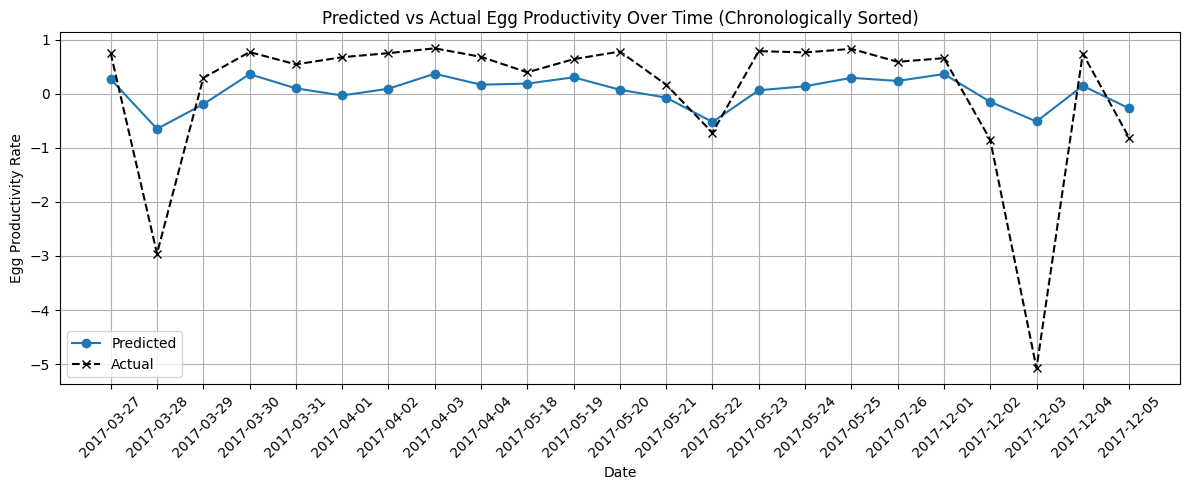

In [22]:
n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine into a single dataframe and sort by date
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time (Chronologically Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Use now globalAttention

In [23]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GlobalAttention
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, edge_feat_dim, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()

        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2)
        
        self.att_pool = GlobalAttention(gate_nn=torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid()
        ))
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Optional: concatenate edge_attr info into node features or apply custom logic
        # Currently unused because GATConv does not support edge_attr directly

        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.att_pool(x, batch)
        return self.mlp(x).squeeze(1)

# Normalize targets
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kf = KFold(n_splits=5, shuffle=True, random_state=0)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    losses = []
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def eval_model(model, loader, criterion):
    model.eval()
    losses = []
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            losses.append(loss.item())
            preds.extend(out.cpu().numpy())
            targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(targets, preds, squared=False)
    mae = mean_absolute_error(targets, preds)
    return np.mean(losses), rmse, mae, preds, targets

all_rmse = []
all_mae = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"Fold {fold + 1}")
    train_dataset = [graphs_padded[i] for i in train_idx]
    val_dataset = [graphs_padded[i] for i in val_idx]

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    model = GATGraphRegressor(in_node_feats=max_node_dim, edge_feat_dim=max_edge_dim).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, rmse, mae, _, _ = eval_model(model, val_loader, criterion)
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_model_ga_fold{fold}.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(f"best_model_ga_fold{fold}.pt"))
    _, rmse, mae, preds, targets = eval_model(model, val_loader, criterion)
    all_rmse.append(rmse)
    all_mae.append(mae)
    print(f"Fold {fold + 1} final RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f}")
print(f"Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

Fold 1


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.0946 | Val Loss: 0.6393 | RMSE: 0.7996 | MAE: 0.7248
Epoch 1 | Train Loss: 1.0862 | Val Loss: 0.6340 | RMSE: 0.7963 | MAE: 0.7209
Epoch 2 | Train Loss: 1.0672 | Val Loss: 0.6136 | RMSE: 0.7833 | MAE: 0.7073
Epoch 3 | Train Loss: 1.0080 | Val Loss: 0.5477 | RMSE: 0.7400 | MAE: 0.6665
Epoch 4 | Train Loss: 0.8785 | Val Loss: 0.4533 | RMSE: 0.6733 | MAE: 0.5976
Epoch 5 | Train Loss: 0.7315 | Val Loss: 0.2831 | RMSE: 0.5321 | MAE: 0.4802
Epoch 6 | Train Loss: 0.5820 | Val Loss: 0.2026 | RMSE: 0.4501 | MAE: 0.3692
Epoch 7 | Train Loss: 0.4446 | Val Loss: 0.1549 | RMSE: 0.3935 | MAE: 0.2841
Epoch 8 | Train Loss: 0.3803 | Val Loss: 0.1649 | RMSE: 0.4061 | MAE: 0.2797
Epoch 9 | Train Loss: 0.3572 | Val Loss: 0.1755 | RMSE: 0.4190 | MAE: 0.2910
Epoch 10 | Train Loss: 0.3510 | Val Loss: 0.2035 | RMSE: 0.4511 | MAE: 0.3076
Epoch 11 | Train Loss: 0.3476 | Val Loss: 0.1953 | RMSE: 0.4419 | MAE: 0.3038
Epoch 12 | Train Loss: 0.3359 | Val Loss: 0.1946 | RMSE: 0.4412 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.0968 | Val Loss: 0.6433 | RMSE: 0.8021 | MAE: 0.7301
Epoch 1 | Train Loss: 1.0780 | Val Loss: 0.6597 | RMSE: 0.8122 | MAE: 0.7401
Epoch 2 | Train Loss: 1.0508 | Val Loss: 0.6659 | RMSE: 0.8160 | MAE: 0.7419
Epoch 3 | Train Loss: 1.0172 | Val Loss: 0.6417 | RMSE: 0.8011 | MAE: 0.7265
Epoch 4 | Train Loss: 0.9591 | Val Loss: 0.6018 | RMSE: 0.7758 | MAE: 0.7042
Epoch 5 | Train Loss: 0.8599 | Val Loss: 0.5153 | RMSE: 0.7178 | MAE: 0.6475
Epoch 6 | Train Loss: 0.7127 | Val Loss: 0.4136 | RMSE: 0.6431 | MAE: 0.5670
Epoch 7 | Train Loss: 0.5329 | Val Loss: 0.2759 | RMSE: 0.5252 | MAE: 0.4333
Epoch 8 | Train Loss: 0.4176 | Val Loss: 0.2961 | RMSE: 0.5441 | MAE: 0.4399
Epoch 9 | Train Loss: 0.3691 | Val Loss: 0.2505 | RMSE: 0.5005 | MAE: 0.3957
Epoch 10 | Train Loss: 0.3578 | Val Loss: 0.2595 | RMSE: 0.5094 | MAE: 0.4015
Epoch 11 | Train Loss: 0.3431 | Val Loss: 0.1963 | RMSE: 0.4430 | MAE: 0.3389
Epoch 12 | Train Loss: 0.3465 | Val Loss: 0.2080 | RMSE: 0.4561 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.0478 | Val Loss: 0.8742 | RMSE: 0.9350 | MAE: 0.8286
Epoch 1 | Train Loss: 1.0303 | Val Loss: 0.8664 | RMSE: 0.9308 | MAE: 0.8236
Epoch 2 | Train Loss: 1.0028 | Val Loss: 0.8525 | RMSE: 0.9233 | MAE: 0.8132
Epoch 3 | Train Loss: 0.9696 | Val Loss: 0.8157 | RMSE: 0.9032 | MAE: 0.7925
Epoch 4 | Train Loss: 0.9194 | Val Loss: 0.7509 | RMSE: 0.8666 | MAE: 0.7558
Epoch 5 | Train Loss: 0.8251 | Val Loss: 0.6169 | RMSE: 0.7854 | MAE: 0.6796
Epoch 6 | Train Loss: 0.7033 | Val Loss: 0.4912 | RMSE: 0.7008 | MAE: 0.5800
Epoch 7 | Train Loss: 0.5566 | Val Loss: 0.3648 | RMSE: 0.6040 | MAE: 0.4519
Epoch 8 | Train Loss: 0.4475 | Val Loss: 0.2573 | RMSE: 0.5072 | MAE: 0.3663
Epoch 9 | Train Loss: 0.3788 | Val Loss: 0.2283 | RMSE: 0.4778 | MAE: 0.3326
Epoch 10 | Train Loss: 0.3653 | Val Loss: 0.2339 | RMSE: 0.4836 | MAE: 0.3238
Epoch 11 | Train Loss: 0.3367 | Val Loss: 0.2163 | RMSE: 0.4651 | MAE: 0.3304
Epoch 12 | Train Loss: 0.3377 | Val Loss: 0.2312 | RMSE: 0.4808 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 1.0436 | Val Loss: 0.8262 | RMSE: 0.9089 | MAE: 0.8137
Epoch 1 | Train Loss: 1.0319 | Val Loss: 0.8098 | RMSE: 0.8999 | MAE: 0.8030
Epoch 2 | Train Loss: 1.0009 | Val Loss: 0.7698 | RMSE: 0.8774 | MAE: 0.7784
Epoch 3 | Train Loss: 0.9353 | Val Loss: 0.6758 | RMSE: 0.8221 | MAE: 0.7261
Epoch 4 | Train Loss: 0.8207 | Val Loss: 0.5621 | RMSE: 0.7497 | MAE: 0.6421
Epoch 5 | Train Loss: 0.6839 | Val Loss: 0.4491 | RMSE: 0.6702 | MAE: 0.5350
Epoch 6 | Train Loss: 0.5539 | Val Loss: 0.3479 | RMSE: 0.5898 | MAE: 0.4418
Epoch 7 | Train Loss: 0.4616 | Val Loss: 0.2776 | RMSE: 0.5268 | MAE: 0.3898
Epoch 8 | Train Loss: 0.4087 | Val Loss: 0.2471 | RMSE: 0.4971 | MAE: 0.3564
Epoch 9 | Train Loss: 0.3740 | Val Loss: 0.2316 | RMSE: 0.4812 | MAE: 0.3425
Epoch 10 | Train Loss: 0.3544 | Val Loss: 0.2355 | RMSE: 0.4852 | MAE: 0.3441
Epoch 11 | Train Loss: 0.3413 | Val Loss: 0.2387 | RMSE: 0.4886 | MAE: 0.3511
Epoch 12 | Train Loss: 0.3302 | Val Loss: 0.2293 | RMSE: 0.4788 | MAE: 0.3

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'nn.glob.GlobalAttention' is deprecated, use 'nn.aggr.AttentionalAggregation' instead
  warnings.warn(out)


Epoch 0 | Train Loss: 0.7815 | Val Loss: 1.9627 | RMSE: 1.4010 | MAE: 1.0259
Epoch 1 | Train Loss: 0.7730 | Val Loss: 1.9477 | RMSE: 1.3956 | MAE: 1.0131
Epoch 2 | Train Loss: 0.7563 | Val Loss: 1.9128 | RMSE: 1.3830 | MAE: 0.9892
Epoch 3 | Train Loss: 0.7231 | Val Loss: 1.8435 | RMSE: 1.3578 | MAE: 0.9540
Epoch 4 | Train Loss: 0.6525 | Val Loss: 1.6989 | RMSE: 1.3034 | MAE: 0.8952
Epoch 5 | Train Loss: 0.5258 | Val Loss: 1.4719 | RMSE: 1.2132 | MAE: 0.7915
Epoch 6 | Train Loss: 0.3752 | Val Loss: 1.2360 | RMSE: 1.1118 | MAE: 0.6158
Epoch 7 | Train Loss: 0.2640 | Val Loss: 1.0376 | RMSE: 1.0186 | MAE: 0.5032
Epoch 8 | Train Loss: 0.2128 | Val Loss: 0.9608 | RMSE: 0.9802 | MAE: 0.4422
Epoch 9 | Train Loss: 0.1975 | Val Loss: 0.9005 | RMSE: 0.9490 | MAE: 0.4329
Epoch 10 | Train Loss: 0.1871 | Val Loss: 0.9000 | RMSE: 0.9487 | MAE: 0.4169
Epoch 11 | Train Loss: 0.1827 | Val Loss: 0.8991 | RMSE: 0.9482 | MAE: 0.4194
Epoch 12 | Train Loss: 0.1785 | Val Loss: 0.8644 | RMSE: 0.9297 | MAE: 0.4

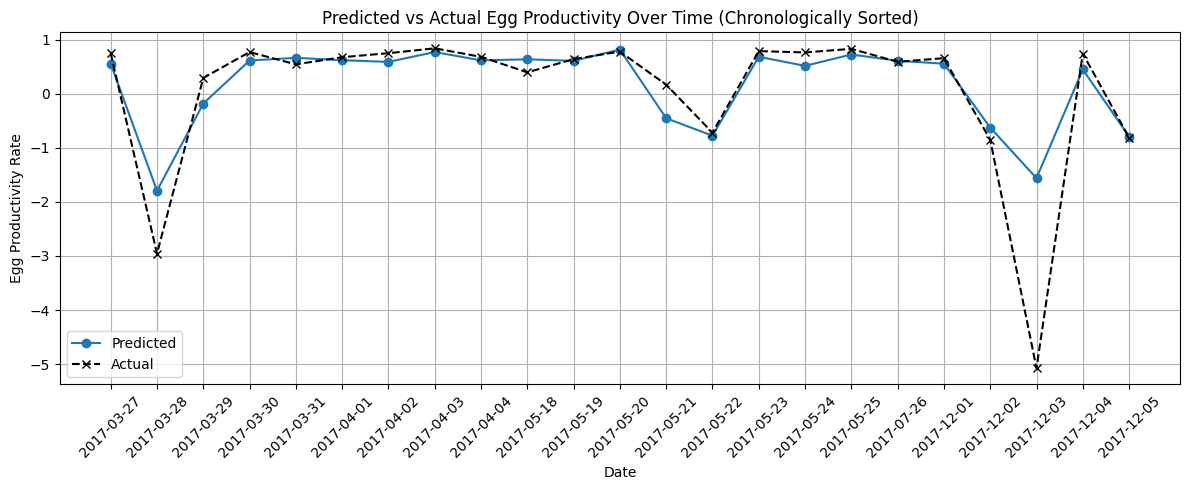

In [24]:
n = len(preds)
dates = eggs_per_day_df["date"].iloc[-n:].reset_index(drop=True)

# Combine into a single dataframe and sort by date
df_plot = pd.DataFrame({
    "date": dates,
    "predicted": preds,
    "actual": targets
}).sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["predicted"], label="Predicted", marker='o')
plt.plot(df_plot["date"], df_plot["actual"], label="Actual", linestyle="--", color="black", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Egg Productivity Rate")
plt.title("Predicted vs Actual Egg Productivity Over Time (Chronologically Sorted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 7) Evaluate

In [25]:
import pandas as pd

target = pd.read_csv("/kaggle/input/private-hen-productivity-target-labels/production_net.csv", sep=";")
eggs_per_day_df = target[["date", "Laying.rate...."]].rename(columns={"Laying.rate....": "productivity rate"})
eggs_per_day_df['productivity rate'] = eggs_per_day_df['productivity rate'].str.replace(',', '.').astype(float)
eggs_per_day_df.head(5)

,date,productivity rate
0,2017-02-27,94.960274
1,2017-03-01,94.260145
2,2017-04-25,92.655367
3,2017-07-12,89.730444
4,2017-07-22,88.271474


In [26]:
mean_eggs = eggs_per_day_df["productivity rate"].mean()
std_eggs = eggs_per_day_df["productivity rate"].std()

print(f"Mean productivity rate: {mean_eggs:.2f}")
print(f"Standard deviation of productivity rate: {std_eggs:.2f}")

Mean productivity rate: 87.16
Standard deviation of productivity rate: 8.34


### Model Evaluation: Egg Productivity Prediction

#### Baseline Statistics
- **Mean productivity rate**: 87.16  
- **Standard deviation**: 8.34  

---

#### Model 1: Global Mean Pooling
- **Average RMSE**: 6.3432 ± 1.6594
- **Average MAE**: 4.8460 ± 1.2689 
- **Analysis**:  
  Highest error among all models. The high MAE and RMSE suggest that mean pooling fails to capture meaningful variation between nodes, likely due to oversimplification of node-level features.

---

#### Model 2: Global Max Pooling
- **Average RMSE**: 0.7737 ± 0.2112
- **Average MAE**: 0.6212 ± 0.0937
- **Analysis**:  
  Substantial improvement over mean pooling, particularly in RMSE. Max pooling may help highlight dominant node signals, but still shows weak overall performance.

---

#### Model 3: Global Attention Pooling
- **Average RMSE**: 0.5113 ± 0.1472
- **Average MAE**: 0.3247 ± 0.0232
- **Analysis**:  
  Best performance overall. The attention mechanism helps the model focus on the most relevant nodes, improving accuracy and reducing error. MAE (0.3557) is roughly 1/23rd of the standard deviation, indicating strong predictive performance relative to data variability.

---

#### Overall Insights
- Switching from mean or max pooling to attention pooling substantially reduced prediction error.  
- Attention pooling outperformed both mean and max in terms of both RMSE and MAE.  
- The lower standard deviation in model 3's error metrics suggests more consistent predictions across samples.
- The MAE (0.3557) of attention pooling is roughly **1/26th** of the standard deviation, indicating a strong predictive performance relative to data variability.